In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from statsmodels.tsa.api import UnobservedComponents 

State models are similiar to statistical models, but with a more "real-world" motivation.  They address concerns, that emerge in real-world problems, like measurement errors and the usage of prior knowledge/belief into estimates. 
This occurs, when e.g. the true state can't be measured directly. State space models also rely on dynamics of a system, how the true state of the world evolves over time. 

## Bayesian Structural Time Series

Bayesian Structural Time series (BSTS) are related to linear gaussian model. The main difference is, that Bayesian structural time series provide a way to use preexisting components to build more complex models that can refletc known facts or interesting hypotheses about a system. 

There are four steos to fit a BSTS  model:
- defining structural model, including specifiication of priors
- Kalman filter is applied to update estimates of state based on observed data
- spike-and-slab method is used to perform variable selection within the structural model
- Bayesian model averaging is applied to combine results for the purpose of generating a forecast

code opy and paste

In [2]:
data = pd.read_csv("../data/global_temps.csv")

In [3]:
data.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


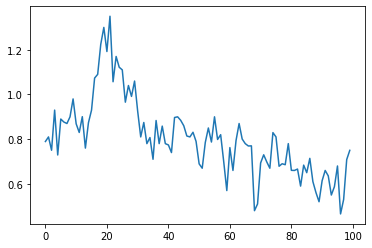

In [4]:
data.Mean[:100].plot()

In [5]:
data = data.pivot(index='Date', columns='Source', values='Mean')

In [6]:
data.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


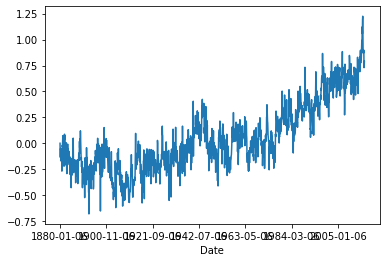

In [7]:
data.GCAG.plot()

In [8]:
data.index = pd.to_datetime(data.index)

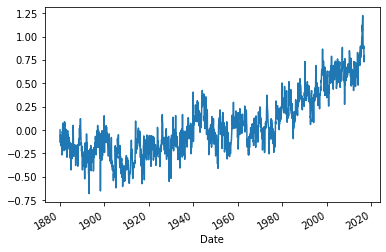

In [9]:
data.GCAG.plot()

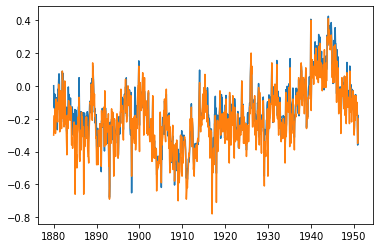

In [10]:
plt.plot(data['1880':'1950'][['GCAG', 'GISTEMP']])

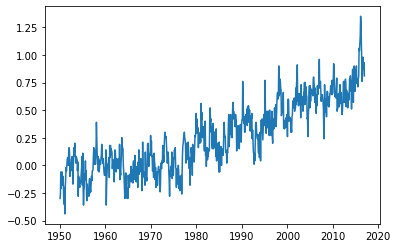

In [11]:
plt.plot(data['1950':][['GISTEMP']])

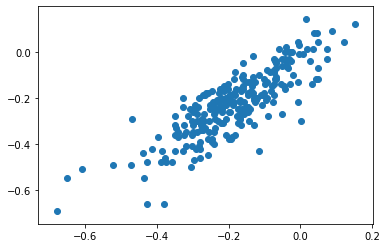

In [12]:
plt.scatter(data['1880':'1900'][['GCAG']], data['1880':'1900'][['GISTEMP']])

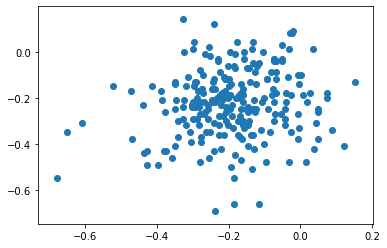

In [13]:
plt.scatter(data['1880':'1899'][['GCAG']], data['1881':'1900'][['GISTEMP']])

In [14]:
np.corrcoef(data['1880':'1899'].GCAG, data['1881':'1900'].GISTEMP)

array([[1.        , 0.15464057],
       [0.15464057, 1.        ]])

In [15]:
data['1880':'1899'][['GCAG']].head()

Source,GCAG
Date,
1880-01-06,0.0009
1880-02-06,-0.1229
1880-03-06,-0.1357
1880-04-06,-0.0499
1880-05-06,-0.0738


In [16]:
data['1881':'1900'][['GISTEMP']].head()

Source,GISTEMP
Date,
1881-01-06,-0.10
1881-02-06,-0.14
1881-03-06,0.01
1881-04-06,-0.03
1881-05-06,-0.04


In [17]:
min(data.index)

Timestamp('1880-01-06 00:00:00')

In [18]:
max(data.index)

Timestamp('2016-12-06 00:00:00')

In [19]:
train = data['1960':]

In [20]:
# smooth trend model without seasonal or cyclical components
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}

In [21]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
gcag_mod = UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_mod.fit()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


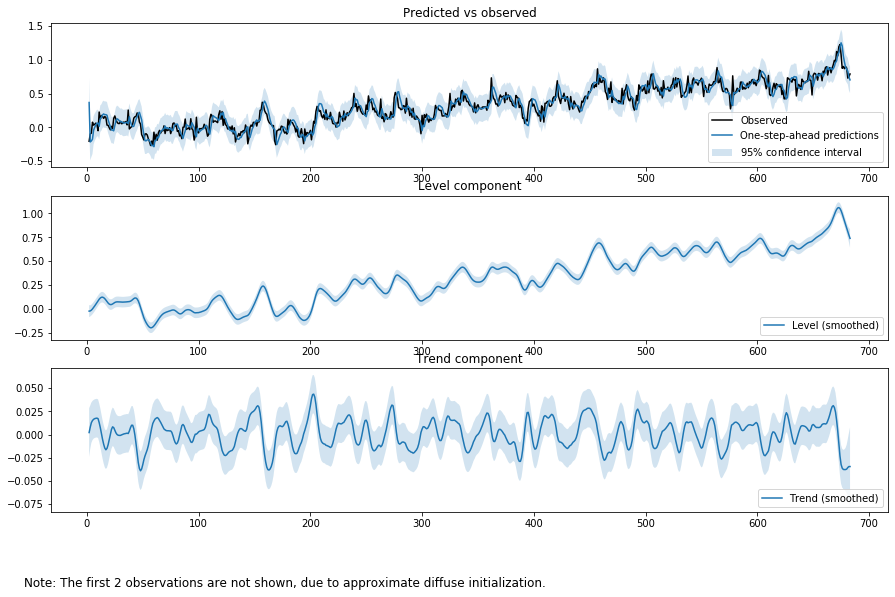

In [22]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [23]:
# Perform rolling prediction and multistep forecast
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train['GCAG'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

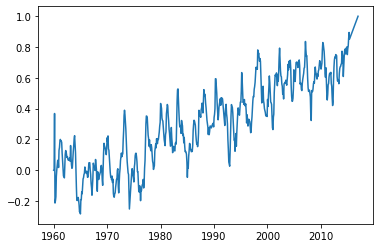

In [24]:
plt.plot(predict)

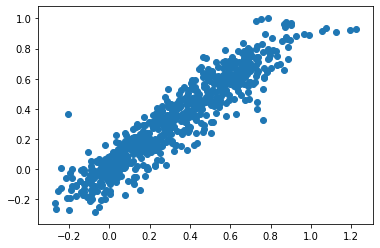

In [25]:
plt.scatter(train['GCAG'], predict)

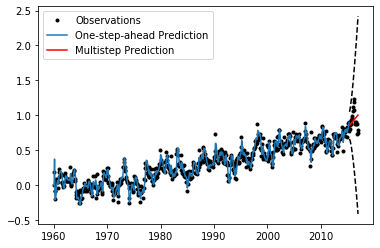

In [26]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['GCAG'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

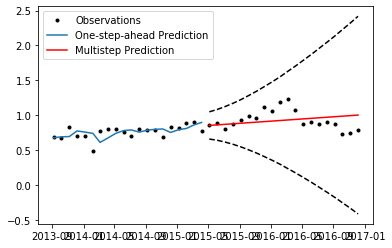

In [27]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

In [28]:
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


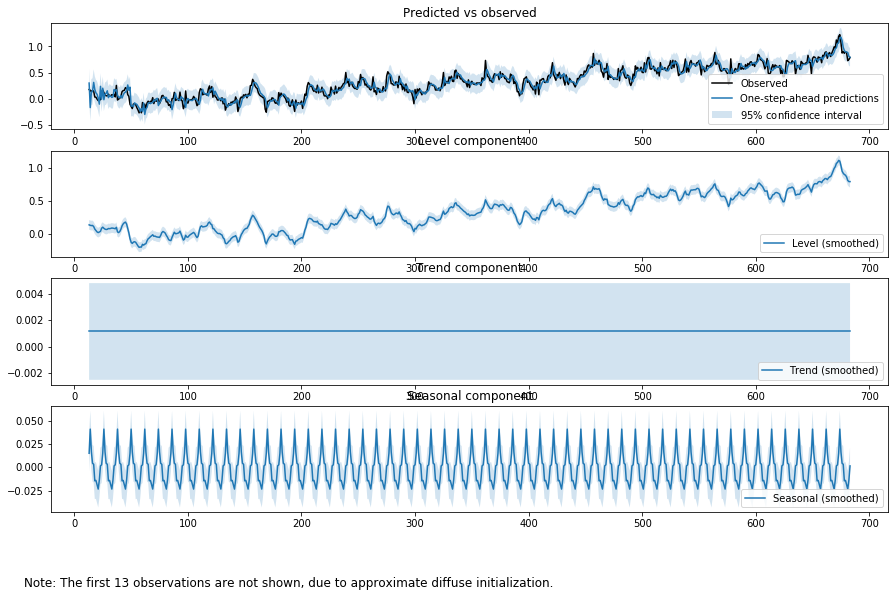

In [29]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [30]:
np.corrcoef(gcag_res.predict(), train['GCAG'])

array([[1.        , 0.93765546],
       [0.93765546, 1.        ]])

In [31]:
np.mean(np.abs(gcag_res.predict() - train['GCAG']))

0.07721215185716095

In [32]:
np.mean(np.abs(res.predict() - train['GCAG']))

0.0720338014474474

In [33]:
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = UnobservedComponents(train['GCAG'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


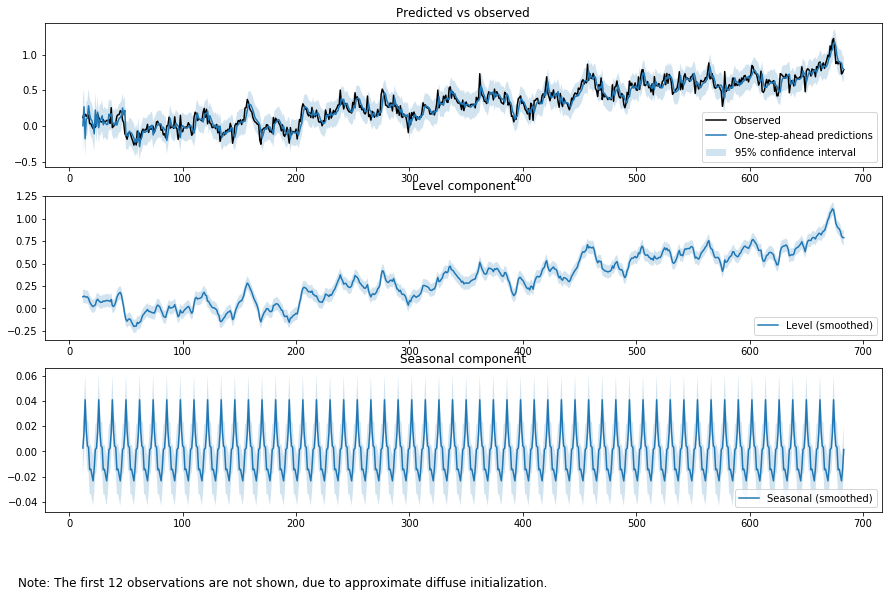

In [34]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [35]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

0.07157731548929354

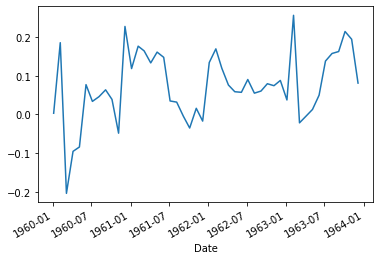

In [36]:
train[:48].GCAG.plot()

In [37]:
np.corrcoef(ll_level_res.predict(), train['GCAG'])

array([[1.        , 0.94500482],
       [0.94500482, 1.        ]])

In [38]:
np.corrcoef(train['GCAG'].iloc[:-1, ], train['GCAG'].iloc[1:, ])

array([[1.        , 0.94036119],
       [0.94036119, 1.        ]])

In [39]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

0.07157731548929354

In [40]:
np.mean(np.abs(train['GCAG'].iloc[:-1, ].values, train['GCAG'].iloc[1:, ].values))

0.3475446559297218

## Hidden Markov Models

HMM are a particularly useful way of modeling time series, because it is unsupervised learning in time series analysis. A HMM uses nonlinear processes, which jump between discrete states.


In an HMM, the system is fully described with the information about:<br>
- transistion probability of going from x(t) to x(t)+1 <br>
- emission probability or probability of observation y(t) given x(t)
- initial state of the system

### Baum Welch algorithm

In an HMM for the estimation of the paramters the Baum Welch algorithm is used. The tasks are: <br>
- identify the distinct emission probabilities for each possible hidden state and identify the transition probabilities from each possible hidden state to each other possible hidden state.
- identify the most likely hidden state for each time step given the full history of observations.

### Viterbi algorithm

Once parameters have been estimated via Baum-Welch algorithm, the next problem is, what is the most likely series of underlying states, given the measured time series of observed values.



copy paste example

In [41]:
nile = pd.read_csv("../data/Nile.csv", index_col = 0)

In [42]:
nile.head()

,year,val
1,1871,1120
2,1872,1160
3,1873,963
4,1874,1210
5,1875,1160


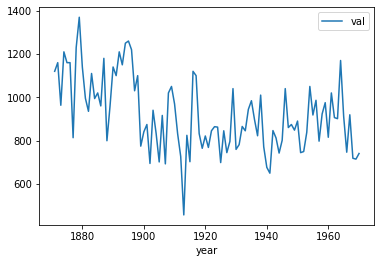

In [43]:
nile.plot(x="year")

In [44]:
vals = np.expand_dims(nile.val.values, 1)
n_states = 2
model = hmm.GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
hidden_states = model.predict(vals)

In [45]:
np.bincount(hidden_states)

array([72, 28])

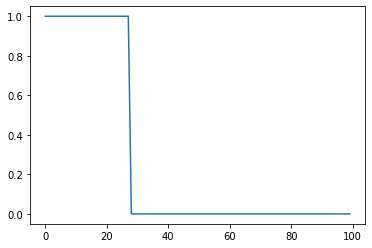

In [46]:
pd.Series(hidden_states).plot()

In [47]:
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = hmm.GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    
    return hidden_states, mus, sigmas, transmat, model

In [48]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 2)

[ 850.75596948 1097.15261711]
[124.44593534 133.74749638]


In [49]:
def plot_states(ts_vals, states, time_vals):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Year)')
    ax1.set_ylabel('Nile river flow',         color=color)
    ax1.plot(time_vals, ts_vals,      color=color)
    ax1.tick_params(axis='y',            labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states,     color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

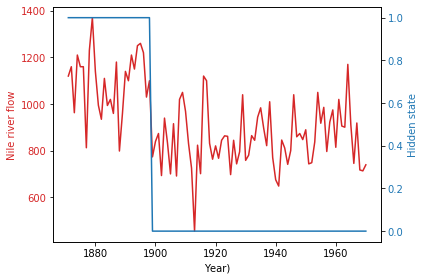

In [50]:
plot_states(nile.val, hidden_states, nile.year)

In [51]:
np.where(hidden_states == 0)

(array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
        96, 97, 98, 99]),)

In [52]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 3)

[1097.27216026  796.06732375  884.87213564]
[133.0357056   67.19550566 138.81884828]


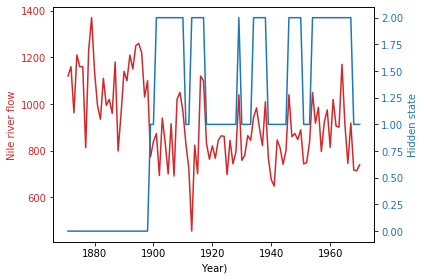

In [53]:
plot_states(nile.val, hidden_states, nile.year)

In [54]:
mus

array([1097.27216026,  796.06732375,  884.87213564])

In [55]:
np.set_printoptions(precision = 3, suppress = True)

In [56]:
transmat

array([[0.964, 0.036, 0.   ],
       [0.   , 0.508, 0.492],
       [0.   , 0.305, 0.695]])

In [57]:
mus

array([1097.272,  796.067,  884.872])

In [58]:
res = np.squeeze(model.sample(1000)[0])

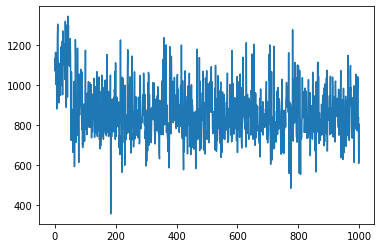

In [59]:
plt.plot(res)

In [60]:
hidden_states, mus, sigmas, transmat, model = fitHMM(res, 3)

[ 800.223 1109.805  887.043]
[ 65.912 112.478 135.308]


In [61]:
def plot_states_no_time(ts_vals, states):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Time)')
    ax1.set_ylabel('Value',        color=color)
    ax1.plot(ts_vals,              color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(states,        color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

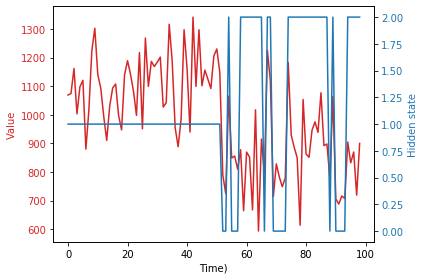

In [62]:
plot_states_no_time(res[1:100], hidden_states[1:100])

## Kalman Filter

The Kalman filter is a well-developed and widely used method for incorporting new information from a time series and combining it with previous known information to estimate an underlying state.

In [63]:
steps = 100
acceleration = [0.5] * steps

x_pos = [0] * steps
v = [0] * steps

for ts in range(1,100):
    x_pos[ts] = v[ts-1] * 2 + x_pos[ts-1] + 1/2 * np.power(acceleration[ts-1], 2)
    x_pos[ts] += abs(float(np.random.normal(1, 20, 1)))
    v[ts] = v[ts-1] + 2 * acceleration[ts-1]

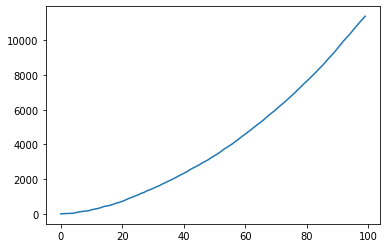

In [64]:
pd.Series(x_pos).plot()

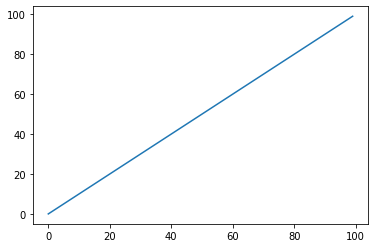

In [65]:
pd.Series(v).plot()

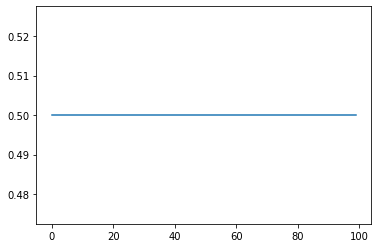

In [66]:
pd.Series(acceleration).plot()

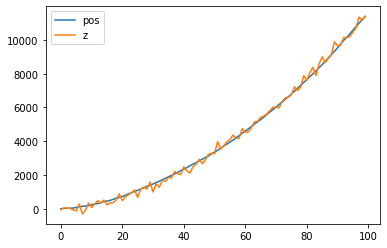

In [67]:
z= list(np.array(x_pos)+np.random.normal(1, 200, len(x_pos)))
pd.DataFrame({"pos":x_pos, "z": z}).plot()

In [68]:
np.zeros(100)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [69]:
def simple_kalman(z, Q, R):
    dim_State = Q.shape[0]
    
    x_hat_minus = np.zeros(len(x_pos))
    x_hat = np.zeros(len(x_pos)) # a posteri estimate of x
    P_minus = np.zeros(len(x_pos))   # a priori error estimate
    P = np.zeros(len(x_pos))         # a posteri error estimate
    K = np.zeros(len(x_pos))         # gain or blending factor

    # intial guesses
    x_hat[0] = 0.0
    P[0] = 1.0

    for k in range(1,len(x_pos)):
        # time update
        x_hat_minus[k] = x_hat[k-1]
        P_minus[k] = P[k-1]+Q

        # measurement update
        K[k] = P_minus[k]/(P_minus[k]+R)
        x_hat[k] = x_hat_minus[k]+K[k]*(z[k]-x_hat_minus[k])
        P[k] = (1-K[k])*P_minus[k]

    return x_hat, x_hat_minus

In [70]:
R = 0.1**2 # estimate of measurement variance, change to see effect

Q = np.eye(1)*10 # process variance

# A = np.array(1)
# H = np.array(1)

x_hat, x_hat_minus = simple_kalman(z, Q, R)

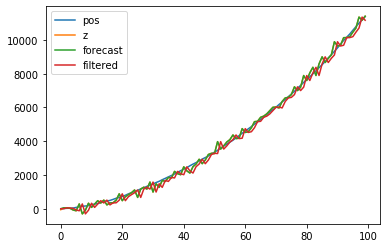

In [71]:
pd.DataFrame({"pos":x_pos, "z": z, "forecast":x_hat, "filtered": x_hat_minus}).plot()